In [21]:
%reload_ext autoreload
%autoreload 2

from RingBuffer import RingBuffer
from pyneurode.spike_sorter import *
from sklearn import preprocessing
from utils import *
import numpy as np 
import random
np.random.seed(0)

In [22]:
data_list = loadPackets('../data/data_packets_M2_D23_1410.pkl')

Reached end. Total segment: 2055


In [23]:
spikes_data_list = [d['spike'] for d in data_list if 'spike' in d.keys()]
df_spikes = makeSpikeDataframe(spikes_data_list)
df_spikes.sort_values('timestamps',inplace=True)
df_spikes.head()

,spike_waveform,time,electrode_ids,channel_ids,spike_id,timestamps
0,"[-0.82845575, -0.72198474, -0.7423228, -0.4827...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,214057
1,"[-0.14917484, -0.71043575, -1.1537359, -1.1359...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,214312
2,"[1.1071546, 0.6718279, -0.68049836, -2.2572246...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,214671
3,"[-0.07389041, -0.022795044, -0.20735654, -0.10...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,215269
4,"[0.16939913, 0.39792666, 0.56199974, 0.4169146...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,215468


(27, 346880)
213760


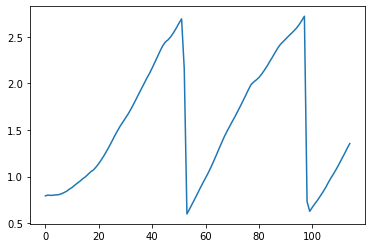

In [24]:
# collect the animal position
Fs=30000
time_bin = 0.1
adc_data = [d['data'] for d in data_list if 'data' in d]
data_ts = [d['data_timestamp'] for d in data_list if 'data_timestamp' in d ]
adc_data = np.concatenate(adc_data,1)
print(adc_data.shape)
start_timestamp = data_ts[0]
print(start_timestamp)

# Extract and time-bin the data
segment_size = int(Fs*time_bin)
position, _ = simpleDownSample(adc_data[20,:,None], segment_size)
plt.plot(position)

neuroData = adc_data[:16,:]

In [25]:
def syncSpikeTime2(df_spike,data,spikeIdx = 0, searchLength=5000,noChan=4):
    #synchronize the time stamp of the spike and data
    
    first_spike_waveform = df_spike.iloc[spikeIdx].spike_waveform.reshape(noChan,-1)
    first_spike_ts = df_spike.iloc[spikeIdx].timestamps
    spike_length = first_spike_waveform.shape[1]

    idx,electrode = findMatch(data[:,:searchLength], first_spike_waveform)
    print(f'Match found at {idx} on tetrode {electrode}')
    df_spike.timestamps = df_spike.timestamps - first_spike_ts +  idx + spike_length/2

    return df_spike, idx+1

df_spikes2, idx_shift = syncSpikeTime(df_spikes,neuroData)
df_spikes2.timestamps[0]

Match found at 277 on tetrode 1


297.0

In [26]:
df_spikes.timestamps[0] - (data_ts[0]+idx_shift)

0.0

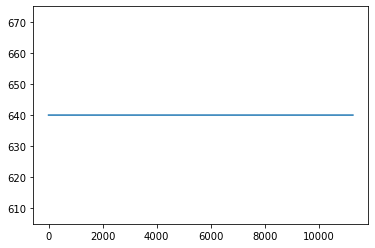

In [63]:
plt.plot(np.diff(data_ts))

In [64]:
data_ts[:10]

[776320,
 776960,
 777600,
 778240,
 778880,
 779520,
 780160,
 780800,
 781440,
 782080]

In [65]:
df_spikes

,spike_waveform,time,electrode_ids,channel_ids,spike_id,timestamps
0,"[1.0382471, 0.267646, -0.31060556, -0.48534635...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,533.0
1,"[-0.15610476, -0.78465533, -1.0079, -0.7250521...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,741.0
2,"[-0.68814534, -0.6663029, -0.088886306, 0.2488...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,937.0
3,"[-0.5647071, -0.7932088, -0.9721054, -0.733956...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,970.0
4,"[0.9286076, 0.7933346, 0.7343918, 0.9987815, 0...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,1215.0
...,...,...,...,...,...,...
30303,"[0.44175854, 0.5096807, 0.54302853, 0.72615194...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30303,7203373.0
30304,"[0.8300648, 0.93642336, 0.91210496, 1.3845216,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30304,7203404.0
30305,"[0.48132294, -0.6182664, -1.0447532, -0.663976...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30305,7203611.0
30306,"[0.75245535, 0.252113, -0.41159463, -0.9729137...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30306,7203693.0


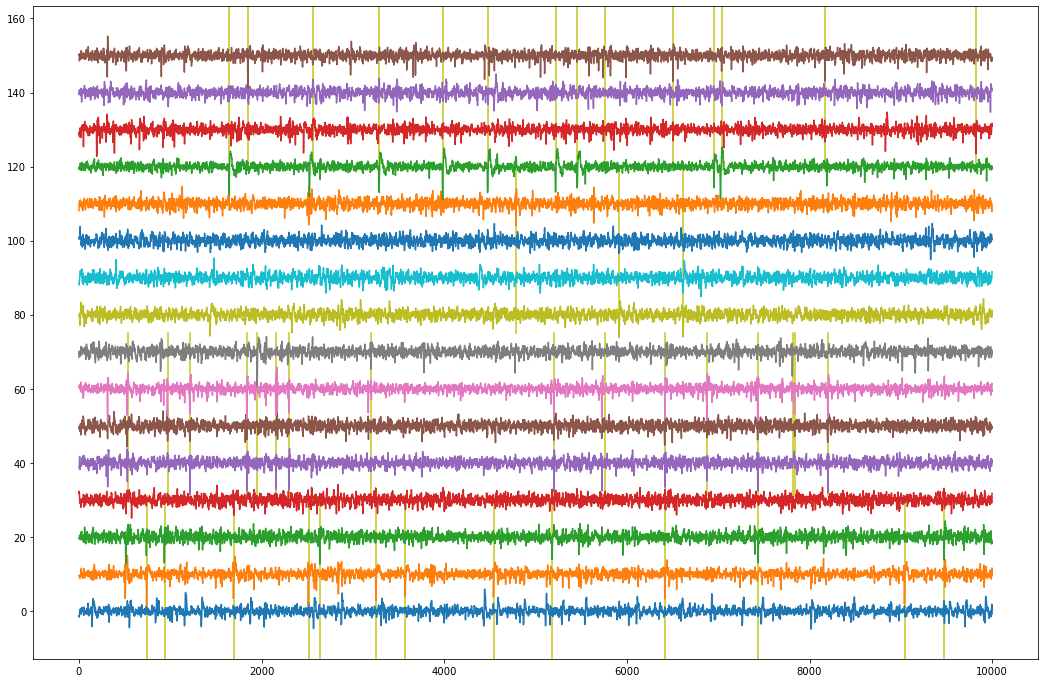

In [71]:
plot_range = 10000
timestamps = df_spikes2.timestamps
plot_spikeEvent(neuroData,timestamps,plot_range,df_spikes2.electrode_ids.values,color='y',alpha=0.9,figsize=(18,12))


In [72]:
data_ts[0]+533

776853

In [78]:
df_spikes.timestamps[0]

777492

In [79]:
df_spikes.timestamps[0] - (data_ts[0]+533)

639